Sample code from Stefan Lee

In [1]:
!pip install pytreebank
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"

import torch
torch.manual_seed(0)
import numpy as np
np.random.seed(0)


  Preparing metadata (setup.py) ... done
  Created wheel for pytreebank: filename=pytreebank-0.2.7-py3-none-any.whl size=37070 sha256=f76df52bde688d1d2ff1dcbd9a2f44508e55206193e3c21b176f2191b4c97405
  Stored in directory: /Users/johnnybui/Library/Caches/pip/wheels/c8/4d/50/2081f2e6d56296520e1db138d8bc2d098689d398d39f8793b2
Successfully built pytreebank


/Users/johnnybui/opt/miniconda3/envs/torch-mps/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from collections import Counter
from re import sub, compile
import matplotlib.pyplot as plt
import numpy as np
from nltk.tokenize import wordpunct_tokenize
from nltk.stem import WordNetLemmatizer
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

class Vocabulary:
	def __init__(self, corpus):
		self.word2idx, self.idx2word, self.freq = self.build_vocab(corpus)
		self.size = len(self.word2idx)

	def text2idx(self, text):
		tokens = self.tokenize(text)
		return [self.word2idx[t] if t in self.word2idx.keys() else self.word2idx['UNK'] for t in tokens]
	
	def idx2text(self, idxs):
		return [self.idx2word[i] if i in self.idx2word.keys() else 'UNK' for i in idxs]


	def tokenize(self, text):
		regex = compile('[^a-zA-Z]')
		tokens = regex.sub(' ', text).lower()
		tokens = wordpunct_tokenize(tokens)
		lemmatizer = WordNetLemmatizer()
		tokens = [lemmatizer.lemmatize(token) for token in tokens]
		tokens = [lemmatizer.lemmatize(token, "v") for token in tokens]
		return tokens


	def build_vocab(self,corpus):
		cntr = Counter(self.tokenize(" ".join(corpus)))
		
		freq = {t:c for t,c in cntr.items()}
		tokens = [t for t,c in cntr.items() if c >= 10]
		word2idx = {t:i+1 for i,t in enumerate(tokens)}
		idx2word = {i+1:t for i,t in enumerate(tokens)}
		word2idx['UNK'] = len(tokens)+1
		idx2word[len(tokens)+1] = 'UNK'
		word2idx[''] = 0
		idx2word[0] = ''
		
		return word2idx, idx2word, freq

[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/johnnybui/nltk_data...
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     /Users/johnnybui/nltk_data...


In [3]:
import io

import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.utils.rnn import pack_padded_sequence, pad_sequence

import pytreebank


class SSTReviews(Dataset):

    def __init__(self,split="train", vocab=None, transform=None):
        
        dataset = pytreebank.load_sst()[split]

        if split == "train":
          lang_data = [ e.to_labeled_lines() for e in dataset]
          lang_data = [item for sublist in lang_data for item in sublist]
        else:
          lang_data = [e.to_labeled_lines()[0] for e in dataset]

        self.reviews = [r[1] for r in lang_data]
        self.labels = [r[0]  for r in lang_data]
        if vocab:
          self.vocab = vocab
        else:
          self.vocab = Vocabulary(self.reviews)
        

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        numeralized = self.vocab.text2idx(self.reviews[idx])
        if len(numeralized) < 5:
          numeralized +=[0]*(5-len(numeralized))
        
        return torch.tensor( numeralized[:min(25, len(numeralized))]), self.labels[idx]

In [4]:
sst_train = SSTReviews(split="train")
sst_val = SSTReviews(split="dev", vocab=sst_train.vocab)
sst_test = SSTReviews(split="test", vocab=sst_train.vocab)
print(sst_train.vocab.size)



8939


In [5]:
from torch.utils.data import DataLoader

def pad_collate(batch):
  (xx, yy) = zip(*batch)
  x_lens = [len(x) for x in xx]

  xx_pad = pad_sequence(xx, batch_first=True, padding_value=0)
  yy = torch.tensor(yy)

  return xx_pad, yy, x_lens

B=256
train_loader = DataLoader(sst_train, batch_size=B, shuffle=True, collate_fn=pad_collate)
val_loader = DataLoader(sst_val, batch_size=200, shuffle=False, collate_fn=pad_collate)
test_loader = DataLoader(sst_test, batch_size=200, shuffle=False, collate_fn=pad_collate)

In [6]:
from tqdm import tqdm 
def train_model(model, epochs=10, lr=0.0003):
    crit = torch.nn.CrossEntropyLoss()
    parameters = filter(lambda p: p.requires_grad, model.parameters())
    optimizer = torch.optim.Adam(parameters, lr=lr, weight_decay=0.0001)
    plots = {"train":[], "val":[]}
    for i in range(epochs):
        model.train()
        sum_loss = 0.0
        total = 0
        correct = 0
        for j, (x, y, l) in tqdm(enumerate(train_loader),total=len(train_loader)):
            #print(y[1].item(), "---",  " ".join(sst_train.vocab.idx2text(x[1,:].flatten().tolist())))
            x = x.cuda()
            y = y.cuda()
            y_pred = model(x, l)
            loss = crit(y_pred, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pred = torch.max(y_pred, 1)[1]
            correct += (pred == y).float().sum()
            sum_loss += loss.item()*y.shape[0]
            total += y.shape[0]
            #if j % 500 == 0:
            #  print(j, len(train_loader), loss.item())

            plots['train'].append( (i, j, loss.item()))
        val_loss, val_acc, val_ae = validation_metrics(model, val_loader)
        print("epoch %d train loss %.3f, train acc %.3f, val loss %.3f, val accuracy %.3f, val mean absolute error %.3f" % 
              (i, sum_loss/total, correct/total, val_loss, val_acc, val_ae))
        plots['val'].append((i, val_loss, val_acc))
    return plots

def validation_metrics (model, loader):
    model.eval()
    correct = 0
    total = 0
    sum_loss = 0.0
    sum_ae = 0.0
    crit = torch.nn.CrossEntropyLoss()
    for x, y, l in loader:
        x = x.cuda()
        y= y.cuda()
        
        y_hat = model(x, l)
        loss = crit(y_hat, y)
        pred = torch.max(y_hat, 1)[1]
        correct += (pred == y).float().sum()
        sum_ae += torch.abs(pred-y).float().sum()
        total += y.shape[0]
        sum_loss += loss.item()*y.shape[0]
    return sum_loss/total, correct/total, sum_ae/total

In [ ]:
import  gensim.downloader
wv = gensim.downloader.load('glove-wiki-gigaword-300')  #slow but only needs to be run once


[==================================================] 100.0% 376.1/376.1MB downloaded


In [ ]:
import torch.nn as nn
import torch.nn.functional as F

# Initialize with random embeddings and then copy over any glove vectors we find from glove
embeddings = torch.randn(sst_train.vocab.size+1, 300)
cnt = 0
for i,w in sst_train.vocab.idx2word.items():
  if w in wv:
    embeddings[i,:] = torch.tensor(wv[w][:])
    cnt+=1
print(cnt, "out of", sst_train.vocab.size, "words found")

class WordEncoder(torch.nn.Module):
    def __init__(self, embeddings):
        super().__init__()
        self.embeddings = nn.Embedding.from_pretrained(embeddings, freeze=False, padding_idx=0)
    
    def forward(self, x):
        return F.dropout(self.embeddings(x),0.5)

class SimpleClassifier(torch.nn.Module):
    def __init__(self, insize, outsize, hidden=128):
        super().__init__()
        self.linear = nn.Linear(insize, 128)
        self.linear2 = nn.Linear(128,outsize)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            nn.init.kaiming_normal_(module.weight)
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0.5)

    def forward(self, x):
        out = F.relu(self.linear(x))
        out = F.dropout(out,0.5)
        out = self.linear2(out)
        return out


8774 out of 8939 words found


In [ ]:
class SimpleBoW(torch.nn.Module) :
    def __init__(self, vocab_size) :
        super().__init__()
        self.classifier = SimpleClassifier(vocab_size, 5)
        self.vocab_size = vocab_size

    def forward(self, x, s):
        bow = torch.zeros(x.shape[0], self.vocab_size)
        for b in range(x.shape[0]):
          bow[b, :] = torch.bincount(x[b,:], minlength=self.vocab_size)
        bow = bow.cuda()
        return self.classifier(bow)

model = SimpleBoW(sst_train.vocab.size+1)
model.cuda()
bow_plots = train_model(model)
test_loss, test_acc, test_ae = validation_metrics(model, test_loader)
print("test loss %.3f, test accuracy %.3f, test mean absolute error %.3f" % (test_loss, test_acc, test_ae))

100%|██████████| 1245/1245 [01:37<00:00, 12.75it/s]


epoch 0 train loss 0.888, train acc 0.697, val loss 1.478, val accuracy 0.375, val mean absolute error 0.863


100%|██████████| 1245/1245 [01:37<00:00, 12.82it/s]


epoch 1 train loss 0.727, train acc 0.734, val loss 1.411, val accuracy 0.410, val mean absolute error 0.774


100%|██████████| 1245/1245 [01:37<00:00, 12.73it/s]


epoch 2 train loss 0.653, train acc 0.754, val loss 1.387, val accuracy 0.417, val mean absolute error 0.754


100%|██████████| 1245/1245 [01:37<00:00, 12.76it/s]


epoch 3 train loss 0.608, train acc 0.768, val loss 1.383, val accuracy 0.420, val mean absolute error 0.752


100%|██████████| 1245/1245 [01:36<00:00, 12.86it/s]


epoch 4 train loss 0.576, train acc 0.779, val loss 1.407, val accuracy 0.412, val mean absolute error 0.776


100%|██████████| 1245/1245 [01:37<00:00, 12.76it/s]


epoch 5 train loss 0.553, train acc 0.787, val loss 1.398, val accuracy 0.410, val mean absolute error 0.762


100%|██████████| 1245/1245 [01:37<00:00, 12.71it/s]


epoch 6 train loss 0.536, train acc 0.794, val loss 1.400, val accuracy 0.409, val mean absolute error 0.774


100%|██████████| 1245/1245 [01:37<00:00, 12.75it/s]


epoch 7 train loss 0.520, train acc 0.800, val loss 1.395, val accuracy 0.416, val mean absolute error 0.763


100%|██████████| 1245/1245 [01:37<00:00, 12.74it/s]


epoch 8 train loss 0.508, train acc 0.805, val loss 1.391, val accuracy 0.408, val mean absolute error 0.763


100%|██████████| 1245/1245 [01:37<00:00, 12.79it/s]


epoch 9 train loss 0.499, train acc 0.809, val loss 1.420, val accuracy 0.396, val mean absolute error 0.789
test loss 1.402, test accuracy 0.400, test mean absolute error 0.776
test loss 1.398, test accuracy 0.407, test mean absolute error 0.768


In [ ]:
class SimpleWV(torch.nn.Module) :
    def __init__(self, vocab_size, embeddings) :
        super().__init__()
        self.embed = WordEncoder(embeddings)
        self.classifier = SimpleClassifier(2*embeddings.shape[1], 5)
        
    def forward(self, x, s):
        x = self.embed(x)
        meanx = torch.mean(x, 1)
        maxx, _ = torch.max(x,1)
        x = torch.cat( (meanx, maxx),1)
        return self.classifier(x)

model = SimpleWV(sst_train.vocab.size, embeddings)
model.cuda()
wv_plots = train_model(model)
test_loss, test_acc, test_ae = validation_metrics(model, test_loader)
print("test loss %.3f, test accuracy %.3f, test mean absolute error %.3f" % (test_loss, test_acc, test_ae))


100%|██████████| 1245/1245 [00:23<00:00, 52.85it/s]


epoch 0 train loss 0.866, train acc 0.692, val loss 1.569, val accuracy 0.289, val mean absolute error 1.053


100%|██████████| 1245/1245 [00:23<00:00, 52.14it/s]


epoch 1 train loss 0.722, train acc 0.719, val loss 1.493, val accuracy 0.336, val mean absolute error 0.916


100%|██████████| 1245/1245 [00:23<00:00, 53.22it/s]


epoch 2 train loss 0.653, train acc 0.742, val loss 1.455, val accuracy 0.349, val mean absolute error 0.938


100%|██████████| 1245/1245 [00:23<00:00, 53.19it/s]


epoch 3 train loss 0.616, train acc 0.756, val loss 1.429, val accuracy 0.363, val mean absolute error 0.872


100%|██████████| 1245/1245 [00:23<00:00, 53.08it/s]


epoch 4 train loss 0.587, train acc 0.766, val loss 1.403, val accuracy 0.346, val mean absolute error 0.883


100%|██████████| 1245/1245 [00:23<00:00, 53.42it/s]


epoch 5 train loss 0.566, train acc 0.774, val loss 1.389, val accuracy 0.373, val mean absolute error 0.834


100%|██████████| 1245/1245 [00:23<00:00, 53.46it/s]


epoch 6 train loss 0.548, train acc 0.782, val loss 1.381, val accuracy 0.375, val mean absolute error 0.831


100%|██████████| 1245/1245 [00:23<00:00, 52.74it/s]


epoch 7 train loss 0.535, train acc 0.787, val loss 1.393, val accuracy 0.368, val mean absolute error 0.824


100%|██████████| 1245/1245 [00:22<00:00, 54.33it/s]


epoch 8 train loss 0.524, train acc 0.791, val loss 1.345, val accuracy 0.381, val mean absolute error 0.807


100%|██████████| 1245/1245 [00:22<00:00, 54.69it/s]


epoch 9 train loss 0.514, train acc 0.794, val loss 1.340, val accuracy 0.392, val mean absolute error 0.785
test loss 1.374, test accuracy 0.386, test mean absolute error 0.791
test loss 1.355, test accuracy 0.401, test mean absolute error 0.775


In [ ]:
class SimpleConv(torch.nn.Module) :
    def __init__(self, vocab_size, embeddings, hidden_dim=128) :
        super().__init__()
        self.embed = WordEncoder(embeddings)
        self.classifier = SimpleClassifier(hidden_dim, 5)

        self.conv = nn.Conv1d(embeddings.shape[1], hidden_dim, 5)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Conv1d):
            nn.init.kaiming_normal_(module.weight)
            if module.bias is not None:
                torch.nn.init.constant_(module.bias, 0.5)

    def forward(self, x, s):
        x = self.embed(x)
        x = x.permute(0,2,1)
        x = F.relu(self.conv(x))
        x, _ = torch.max(x,-1)
        out = self.classifier(x)
        return out

model = SimpleConv(sst_train.vocab.size, embeddings)
model.cuda()
conv_plots = train_model(model)
test_loss, test_acc, test_ae = validation_metrics(model, test_loader)
print("test loss %.3f, test accuracy %.3f, test mean absolute error %.3f" % (test_loss, test_acc, test_ae))

100%|██████████| 1245/1245 [00:28<00:00, 43.10it/s]


epoch 0 train loss 0.969, train acc 0.684, val loss 1.602, val accuracy 0.262, val mean absolute error 1.091


100%|██████████| 1245/1245 [00:28<00:00, 43.10it/s]


epoch 1 train loss 0.758, train acc 0.701, val loss 1.562, val accuracy 0.285, val mean absolute error 1.085


100%|██████████| 1245/1245 [00:28<00:00, 43.14it/s]


epoch 2 train loss 0.687, train acc 0.729, val loss 1.480, val accuracy 0.334, val mean absolute error 0.923


100%|██████████| 1245/1245 [00:29<00:00, 42.63it/s]


epoch 3 train loss 0.605, train acc 0.760, val loss 1.404, val accuracy 0.377, val mean absolute error 0.847


100%|██████████| 1245/1245 [00:28<00:00, 43.14it/s]


epoch 4 train loss 0.552, train acc 0.781, val loss 1.390, val accuracy 0.391, val mean absolute error 0.790


100%|██████████| 1245/1245 [00:28<00:00, 43.42it/s]


epoch 5 train loss 0.523, train acc 0.792, val loss 1.330, val accuracy 0.397, val mean absolute error 0.768


100%|██████████| 1245/1245 [00:28<00:00, 43.23it/s]


epoch 6 train loss 0.506, train acc 0.799, val loss 1.342, val accuracy 0.413, val mean absolute error 0.753


100%|██████████| 1245/1245 [00:28<00:00, 43.32it/s]


epoch 7 train loss 0.495, train acc 0.804, val loss 1.395, val accuracy 0.399, val mean absolute error 0.750


100%|██████████| 1245/1245 [00:29<00:00, 42.39it/s]


epoch 8 train loss 0.487, train acc 0.807, val loss 1.378, val accuracy 0.399, val mean absolute error 0.773


100%|██████████| 1245/1245 [00:28<00:00, 43.28it/s]


epoch 9 train loss 0.473, train acc 0.813, val loss 1.360, val accuracy 0.414, val mean absolute error 0.762
test loss 1.377, test accuracy 0.426, test mean absolute error 0.750
test loss 1.383, test accuracy 0.421, test mean absolute error 0.758


In [ ]:
from torch.nn.utils.rnn import pad_packed_sequence

class SimpleGRU(torch.nn.Module) :
    def __init__(self, vocab_size, embeddings, hidden_dim=128) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embed = WordEncoder(embeddings)
        self.classifier = SimpleClassifier(hidden_dim, 5)
        self.gru = nn.GRU(embeddings.shape[1], hidden_dim, batch_first=True)
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.GRU):
          for param_name,weights in module.named_parameters():
            if "weight_hh" in param_name:
              torch.nn.init.eye_(weights)
            if "weight_ih" in param_name:
              torch.nn.init.orthogonal_(weights)
            if "bias" in param_name:
              torch.nn.init.constant_(weights, 0.5)
        
    def forward(self, x, s):
        x = self.embed(x)

        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, ht = self.gru(x_pack)
        out = self.classifier(ht[-1])
        return out

model = SimpleGRU(sst_train.vocab.size, embeddings)
model.cuda()
gru_plots = train_model(model)
test_loss, test_acc, test_ae = validation_metrics(model, test_loader)
print("test loss %.3f, test accuracy %.3f, test mean absolute error %.3f" % (test_loss, test_acc, test_ae))

100%|██████████| 1245/1245 [00:31<00:00, 39.52it/s]


epoch 0 train loss 0.805, train acc 0.705, val loss 1.387, val accuracy 0.380, val mean absolute error 0.842


100%|██████████| 1245/1245 [00:31<00:00, 39.68it/s]


epoch 1 train loss 0.602, train acc 0.760, val loss 1.328, val accuracy 0.404, val mean absolute error 0.770


100%|██████████| 1245/1245 [00:31<00:00, 39.63it/s]


epoch 2 train loss 0.551, train acc 0.779, val loss 1.312, val accuracy 0.411, val mean absolute error 0.740


100%|██████████| 1245/1245 [00:31<00:00, 39.36it/s]


epoch 3 train loss 0.522, train acc 0.793, val loss 1.371, val accuracy 0.394, val mean absolute error 0.757


100%|██████████| 1245/1245 [00:31<00:00, 39.78it/s]


epoch 4 train loss 0.502, train acc 0.801, val loss 1.282, val accuracy 0.417, val mean absolute error 0.745


100%|██████████| 1245/1245 [00:31<00:00, 39.53it/s]


epoch 5 train loss 0.489, train acc 0.807, val loss 1.287, val accuracy 0.441, val mean absolute error 0.704


100%|██████████| 1245/1245 [00:31<00:00, 39.77it/s]


epoch 6 train loss 0.479, train acc 0.810, val loss 1.317, val accuracy 0.412, val mean absolute error 0.739


100%|██████████| 1245/1245 [00:31<00:00, 39.59it/s]


epoch 7 train loss 0.473, train acc 0.812, val loss 1.301, val accuracy 0.428, val mean absolute error 0.709


100%|██████████| 1245/1245 [00:31<00:00, 39.20it/s]


epoch 8 train loss 0.468, train acc 0.815, val loss 1.337, val accuracy 0.437, val mean absolute error 0.715


100%|██████████| 1245/1245 [00:31<00:00, 39.76it/s]


epoch 9 train loss 0.462, train acc 0.818, val loss 1.348, val accuracy 0.432, val mean absolute error 0.726
test loss 1.324, test accuracy 0.443, test mean absolute error 0.702
test loss 1.335, test accuracy 0.445, test mean absolute error 0.707


In [ ]:
class SimpleBiGRU(torch.nn.Module) :
    def __init__(self, vocab_size, embeddings, hidden_dim=128) :
        super().__init__()
        self.hidden_dim = hidden_dim
        self.embed = WordEncoder(embeddings)
        self.classifier = SimpleClassifier(hidden_dim, 5)
        self.gru = nn.GRU(embeddings.shape[1], hidden_dim//2, batch_first=True, bidirectional=True)
        self.apply(self._init_weights)
    
    
    def _init_weights(self, module):
        if isinstance(module, nn.GRU):
          for param_name,weights in module.named_parameters():
            if "weight_hh" in param_name:
              torch.nn.init.eye_(weights)
            if "weight_ih" in param_name:
              torch.nn.init.orthogonal_(weights)
            if "bias" in param_name:
              torch.nn.init.constant_(weights, 0.5)
        
    def forward(self, x, s):
        x = self.embed(x)
        x_pack = pack_padded_sequence(x, s, batch_first=True, enforce_sorted=False)
        out_pack, ht = self.gru(x_pack)
        out, l = pad_packed_sequence(out_pack, batch_first=True)
        rh = out[:,0,self.hidden_dim//2:]
        indx = torch.LongTensor(l-1).unsqueeze(-1).repeat(1,self.hidden_dim).unsqueeze(1)
        fh = torch.gather(out, 1, indx.cuda()).squeeze()
        out = torch.cat( (rh, fh[:,:self.hidden_dim//2]) ,1)

        out = self.classifier(out)
        return out


model = SimpleBiGRU(sst_train.vocab.size, embeddings)
model.cuda()
bigru_plots = train_model(model)
test_loss, test_acc, test_ae = validation_metrics(model, test_loader)
print("test loss %.3f, test accuracy %.3f, test mean absolute error %.3f" % (test_loss, test_acc, test_ae))

100%|██████████| 1245/1245 [00:45<00:00, 27.12it/s]


epoch 0 train loss 0.757, train acc 0.714, val loss 1.415, val accuracy 0.352, val mean absolute error 0.840


100%|██████████| 1245/1245 [00:45<00:00, 27.12it/s]


epoch 1 train loss 0.590, train acc 0.763, val loss 1.345, val accuracy 0.387, val mean absolute error 0.775


100%|██████████| 1245/1245 [00:46<00:00, 26.92it/s]


epoch 2 train loss 0.543, train acc 0.782, val loss 1.308, val accuracy 0.420, val mean absolute error 0.731


100%|██████████| 1245/1245 [00:45<00:00, 27.25it/s]


epoch 3 train loss 0.515, train acc 0.795, val loss 1.291, val accuracy 0.409, val mean absolute error 0.757


100%|██████████| 1245/1245 [00:45<00:00, 27.32it/s]


epoch 4 train loss 0.495, train acc 0.804, val loss 1.282, val accuracy 0.431, val mean absolute error 0.714


100%|██████████| 1245/1245 [00:45<00:00, 27.10it/s]


epoch 5 train loss 0.482, train acc 0.808, val loss 1.310, val accuracy 0.421, val mean absolute error 0.741


100%|██████████| 1245/1245 [00:46<00:00, 26.99it/s]


epoch 6 train loss 0.472, train acc 0.812, val loss 1.301, val accuracy 0.439, val mean absolute error 0.708


100%|██████████| 1245/1245 [00:46<00:00, 26.96it/s]


epoch 7 train loss 0.467, train acc 0.814, val loss 1.332, val accuracy 0.441, val mean absolute error 0.705


100%|██████████| 1245/1245 [00:46<00:00, 26.86it/s]


epoch 8 train loss 0.465, train acc 0.816, val loss 1.329, val accuracy 0.443, val mean absolute error 0.713


100%|██████████| 1245/1245 [00:45<00:00, 27.20it/s]


epoch 9 train loss 0.459, train acc 0.819, val loss 1.345, val accuracy 0.441, val mean absolute error 0.719
test loss 1.347, test accuracy 0.438, test mean absolute error 0.715
test loss 1.349, test accuracy 0.433, test mean absolute error 0.721


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


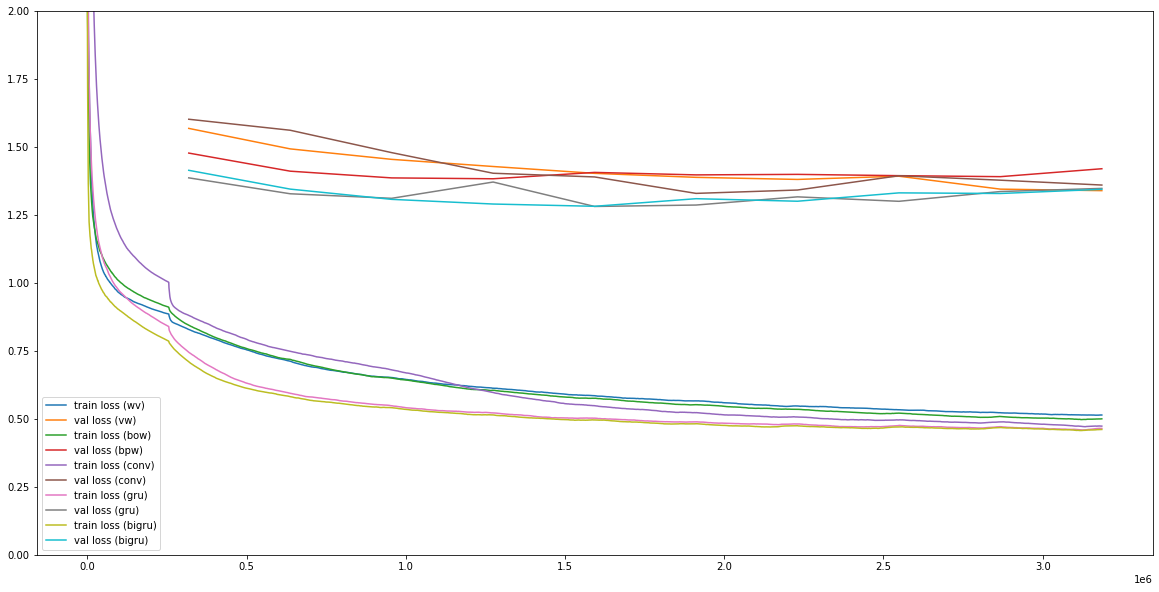

In [ ]:
!pip install bottleneck
import bottleneck as bn

N = 1000
plt.figure(figsize=(20,10))
plots = wv_plots
t = [x[0]*len(sst_train)+x[1]*B for x in plots['train']]
l = bn.move_mean([x[2] for x in plots['train']], window=N, min_count=1)
plt.plot(t,l, label="train loss (wv)")
t = [(x[0]+1)*len(sst_train) for x in plots['val']]
l = [x[1] for x in plots['val']]
plt.plot(t,l, label="val loss (vw)")



plots = bow_plots
t = [x[0]*len(sst_train)+x[1]*B for x in plots['train']]
l = bn.move_mean([x[2] for x in plots['train']], window=N, min_count=1)
plt.plot(t,l, label="train loss (bow)")
t = [(x[0]+1)*len(sst_train) for x in plots['val']]
l = [x[1] for x in plots['val']]
plt.plot(t,l, label="val loss (bpw)")


plots = conv_plots
t = [x[0]*len(sst_train)+x[1]*B for x in plots['train']]
l = bn.move_mean([x[2] for x in plots['train']], window=N, min_count=1)
plt.plot(t,l, label="train loss (conv)")
t = [(x[0]+1)*len(sst_train) for x in plots['val']]
l = [x[1] for x in plots['val']]
plt.plot(t,l, label="val loss (conv)")

plots = gru_plots
t = [x[0]*len(sst_train)+x[1]*B for x in plots['train']]
l = bn.move_mean([x[2] for x in plots['train']], window=N, min_count=1)
plt.plot(t,l, label="train loss (gru)")
t = [(x[0]+1)*len(sst_train) for x in plots['val']]
l = [x[1] for x in plots['val']]
plt.plot(t,l, label="val loss (gru)")

plots = bigru_plots
t = [x[0]*len(sst_train)+x[1]*B for x in plots['train']]
l = bn.move_mean([x[2] for x in plots['train']], window=N, min_count=1)
plt.plot(t,l, label="train loss (bigru)")
t = [(x[0]+1)*len(sst_train) for x in plots['val']]
l = [x[1] for x in plots['val']]
plt.plot(t,l, label="val loss (bigru)")

plt.ylim((0,2))
plt.legend()
plt.show()